In [22]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers datasets accelerate wandb sacrebleu sentencepiece
!pip install -q peft bitsandbytes pyyaml tqdm sacremoses

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import defaultdict
import random
import os
import sys
from tqdm.auto import tqdm
from dataclasses import dataclass, field
from typing import Dict, Any, Optional, List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Подготовка данных

In [25]:
class TranslationDataset(Dataset):
    """Датасет для перевода"""
    def __init__(self, data, split="train"):
        """
        Args:
            data: список словарей с ключами:
                  - 'original': исходный текст
                  - 'russian_translation': русский перевод
                  - 'lang': язык оригинала
            split: "train", "val", "test"
        """
        self.data = data
        self.split = split

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'input': item['original'],
            'output': item['russian_translation'],
            'language': item['lang']
        }

def load_your_dataset():
    try:
        print("Загрузка датасета с Hugging Face...")
        dataset = load_dataset("katykool/samoyed.ic")

        if 'train' in dataset:
            data = dataset['train']
        else:
            data = dataset

        print(f"Загружено {len(data)} примеров из датасета")

        processed_data = []
        skipped = 0

        for i, item in enumerate(data):
            try:
                original = item.get('original', '')
                russian = item.get('russian_translation', '')
                lang = item.get('lang', '')

                if (original and russian and lang and
                    isinstance(original, str) and
                    isinstance(russian, str) and
                    isinstance(lang, str) and
                    len(original.strip()) > 0 and
                    len(russian.strip()) > 0):

                    processed_data.append({
                        'original': original.strip(),
                        'russian_translation': russian.strip(),
                        'lang': lang.strip().lower()
                    })
                else:
                    skipped += 1

            except Exception as e:
                skipped += 1


        print(f"Обработано {len(processed_data)} примеров, пропущено {skipped}")

        if len(processed_data) == 0:
            print("Нет валидных данных")

        return processed_data

    except Exception as e:
        print(f"Ошибка загрузки датасета: {e}")


def create_language_clients(config, tokenizer):
    """
    Создает клиентов по языкам
    """
    all_data = load_your_dataset()

    if not all_data:
        print("Нет данных!")

    # группируем данные по языкам
    data_by_language = defaultdict(list)
    for item in all_data:
        lang = item.get('lang', 'unknown')
        data_by_language[lang].append(item)

    print(f"\nРаспределение данных по языкам:")
    for lang, items in data_by_language.items():
        print(f"  - {lang.upper()}: {len(items)} примеров")

    # создаем DataLoader для каждого клиента
    train_loaders = {}
    val_loaders = {}
    test_loaders = {}

    # ограничиваем количество клиентов, если их больше чем config.npeers
    languages = list(data_by_language.keys())
    if len(languages) > config.npeers:
        languages = languages[:config.npeers]

    for i, lang in enumerate(languages):
        if i >= config.npeers:
            break

        lang_data = data_by_language[lang]
        random.shuffle(lang_data)  # перемешиваем данные

        # разделяем на train/val/test (70/15/15)
        n_total = len(lang_data)
        n_train = int(n_total * 0.7)
        n_val = int(n_total * 0.15)

        train_data = lang_data[:n_train]
        val_data = lang_data[n_train:n_train + n_val]
        test_data = lang_data[n_train + n_val:]

        # пример данных
        # if len(train_data) > 0:
        #     print(f"   Пример: '{train_data[0]['original'][:50]}...' → '{train_data[0]['russian_translation'][:50]}...'")

        # создаем датасеты
        train_dataset = TranslationDataset(train_data, split="train")
        val_dataset = TranslationDataset(val_data, split="val")
        test_dataset = TranslationDataset(test_data, split="test")

        # создаем DataLoaderы
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=lambda x: x,
            num_workers=0
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=lambda x: x,
            num_workers=0
        )

        train_loaders[i] = train_loader
        val_loaders[i] = val_loader
        test_loaders[i] = test_loader

    # общий валидационный загрузчик из всех языков
    all_val_data = []
    for lang_data in data_by_language.values():
        all_val_data.extend(lang_data[:min(5, len(lang_data))])  # по 5 примеров из каждого языка

    random.shuffle(all_val_data)
    combined_val_dataset = TranslationDataset(all_val_data, split="val")
    combined_val_loader = DataLoader(
        combined_val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,
        num_workers=0
    )

    return train_loaders, combined_val_loader, test_loaders

## Конфигурация

In [26]:
project_root = "/content/meritopt"
os.makedirs(project_root, exist_ok=True)

sys.path.append(project_root)

In [27]:
@dataclass
class Config:
    # основные параметры
    seed: int = 42
    epochs: int = 3
    max_steps: int = 50
    batch_size: int = 2
    lr: float = 3e-5

    # модель (не та, что в оригинальной статье -- но зато помещается в Колаб)
    model_type: str = "MarianMT"
    model_checkpoint: str = "Helsinki-NLP/opus-mt-en-ru"

    # данные
    max_seq_len: int = 32

    # federate learning
    fl: bool = True
    npeers: int = 3  # количество клиентов = языков
    mdlr_: float = 0.1
    mdniters_: int = 2
    fl_beta_1: float = 0.9

    # сохранение
    save_every: int = 100
    save_strategy: str = "steps"
    saving_path: str = "/content/drive/MyDrive/meritopt_checkpoints"

    device: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")

    def __post_init__(self):
        import os
        os.makedirs(self.saving_path, exist_ok=True)

## Оптимизатор **Merit**

In [28]:
class MeritFedAdam(torch.optim.Optimizer):
    """Упрощенный MeritFed"""
    def __init__(self, params, config):
        defaults = dict(lr=config.lr, betas=(0.9, 0.98), eps=1e-9)
        super().__init__(params, defaults)

        self.config = config
        self.device = config.device
        self.npeers = config.npeers
        self.weights = torch.ones(config.npeers, device=self.device) / config.npeers
        self.grads_received = 0
        self.step_count = 0

        # инициализация состояний
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['grads'] = [torch.zeros_like(p, device=self.device) for _ in range(config.npeers)]
                state['m'] = torch.zeros_like(p, device=self.device)  # momentum
                state['v'] = torch.zeros_like(p, device=self.device)  # second moment

    def register_worker_grad(self, peer_id):
        """Регистрируем градиент от клиента"""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    self.state[p]['grads'][peer_id].copy_(p.grad)
        self.grads_received += 1

    def step(self, closure=None):
        """Шаг оптимизации"""
        if self.grads_received < self.npeers:
            return

        self.step_count += 1

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # агрегируем градиенты с весами
                agg_grad = torch.zeros_like(p, device=self.device)
                for i in range(self.npeers):
                    agg_grad += state['grads'][i] * self.weights[i]

                # adam update
                beta1, beta2 = group['betas']
                m, v = state['m'], state['v']

                m = beta1 * m + (1 - beta1) * agg_grad
                v = beta2 * v + (1 - beta2) * agg_grad.pow(2)

                m_hat = m / (1 - beta1 ** self.step_count)
                v_hat = v / (1 - beta2 ** self.step_count)

                update = -group['lr'] * m_hat / (v_hat.sqrt() + group['eps'])
                p.data.add_(update)

                # сохраняем моменты
                state['m'].copy_(m)
                state['v'].copy_(v)

        # сбрасываем счетчик
        self.grads_received = 0

        # обновляем веса клиентов (упрощенная версия)
        self._update_client_weights()

    def _update_client_weights(self):
        """Обновление весов клиентов"""
        # В реальной реализации mirror descent
        # Для демонстрации просто немного меняем веса
        noise = torch.randn_like(self.weights) * 0.01
        self.weights += noise
        self.weights = torch.abs(self.weights)  # делаем положительными
        self.weights = self.weights / self.weights.sum()  # нормализуем

    def zero_grad(self):
        """очищаем градиенты"""
        super().zero_grad()
        # очищаем сохраненные градиенты клиентов
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                for i in range(self.npeers):
                    state['grads'][i].zero_()

print("MeritFed оптимизатор создан!")

MeritFed оптимизатор создан!


## Технические штуки

### Логгер

In [29]:
class SimpleLogger:
    def __init__(self):
        self.step = 0
        self.mode = "train"
        self.metrics_history = []

    def set_step(self, step, mode="train"):
        self.step = step
        self.mode = mode

    def get_step(self):
        return self.step

    def add_scalar(self, name, value):
        # print(f"Step {self.step} ({self.mode}): {name} = {value:.4f}")
        self.metrics_history.append({
            'step': self.step,
            'mode': self.mode,
            'name': name,
            'value': value
        })

    def add_dict(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.add_scalar(k, v)

### Перемещение тензоров

In [30]:
def move_to_device(data, device):
    """Перемещает все тензоры в словаре на указанное устройство"""
    if isinstance(data, dict):
        return {k: move_to_device(v, device) for k, v in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, list):
        return [move_to_device(item, device) for item in data]
    else:
        return data

## Federate learning

### Training

In [32]:
def train_epoch_fl_simple(model, tokenizer, optimizer, train_loaders, logger, config, epoch):
    """Упрощенная версия федеративного обучения"""
    model.train()

    loader_iters = {i: iter(loader) for i, loader in train_loaders.items()}

    n_batches = min(len(loader) for loader in train_loaders.values())

    pbar = tqdm(range(n_batches), desc=f"FL Epoch {epoch+1}")
    total_loss = 0

    for batch_idx in pbar:
        current_step = logger.get_step() + 1
        logger.set_step(current_step, "train")

        batch_loss = 0

        for client_id in range(config.npeers):
            try:
                batch = next(loader_iters[client_id])
            except StopIteration:
                loader_iters[client_id] = iter(train_loaders[client_id])
                batch = next(loader_iters[client_id])

            valid_items = []
            for item in batch:
                input_text = item.get('input', '')
                output_text = item.get('output', '')
                if input_text and output_text and isinstance(input_text, str) and isinstance(output_text, str):
                    valid_items.append(item)

            if not valid_items:
                continue

            inputs = [item['input'] for item in valid_items]
            outputs = [item['output'] for item in valid_items]

            try:
                model_inputs = tokenizer(
                    inputs,
                    padding=True,
                    truncation=True,
                    max_length=config.max_seq_len,
                    return_tensors="pt"
                ).to(config.device)

                labels = tokenizer(
                    outputs,
                    padding=True,
                    truncation=True,
                    max_length=config.max_seq_len,
                    return_tensors="pt"
                ).to(config.device)

                # Forward pass
                outputs = model(
                    input_ids=model_inputs['input_ids'],
                    attention_mask=model_inputs['attention_mask'],
                    labels=labels['input_ids']
                )

                loss = outputs.loss
                batch_loss += loss.item()

                # Backward pass
                loss.backward()

                # Регистрируем градиент
                optimizer.register_worker_grad(client_id)

                # Очищаем градиенты для следующего клиента
                if client_id != config.npeers - 1:
                    optimizer.zero_grad()

            except Exception as e:
                continue

        if batch_loss == 0:
            continue

        # Обновляем веса модели
        optimizer.step()
        optimizer.zero_grad()

        # Логирование
        avg_loss = batch_loss / config.npeers
        total_loss += avg_loss

        logger.add_scalar("loss", avg_loss)

        # Логируем веса клиентов
        for i, w in enumerate(optimizer.weights):
            logger.add_scalar(f"weight_client_{i}", w.item())

        pbar.set_postfix({"loss": avg_loss})

        # Сохранение
        if current_step % config.save_every == 0:
            save_model_simple(model, tokenizer, config, iteration=current_step)

        if current_step >= config.max_steps:
            break

    return total_loss / n_batches if n_batches > 0 else 0

### Validation

In [33]:
def validate_simple(model, tokenizer, val_loader, logger, config):
    """Упрощенная валидация"""
    model.eval()
    total_loss = 0

    val_iter = iter(val_loader)
    num_batches = len(val_loader)

    with torch.no_grad():
        for _ in tqdm(range(num_batches), desc="Validation"):
            try:
                batch = next(val_iter)
            except StopIteration:
                break

            inputs = [item['input'] for item in batch]
            outputs = [item['output'] for item in batch]

            model_inputs = tokenizer(
                inputs,
                padding=True,
                truncation=True,
                max_length=config.max_seq_len,
                return_tensors="pt"
            ).to(config.device)

            labels = tokenizer(
                outputs,
                padding=True,
                truncation=True,
                max_length=config.max_seq_len,
                return_tensors="pt"
            ).to(config.device)

            outputs = model(
                input_ids=model_inputs['input_ids'],
                attention_mask=model_inputs['attention_mask'],
                labels=labels['input_ids']
            )

            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    logger.add_scalar("val_loss", avg_loss)

    return avg_loss

### Saving

In [34]:
def save_model_simple(model, tokenizer, config, epoch=None, iteration=None):
    """Упрощенное сохранение модели"""

    if epoch is not None:
        save_path = f"{config.saving_path}/epoch_{epoch}"
    elif iteration is not None:
        save_path = f"{config.saving_path}/step_{iteration}"
    else:
        save_path = f"{config.saving_path}/final"

    os.makedirs(save_path, exist_ok=True)

    # сохраняем модель
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # сохраняем веса если есть
    if hasattr(config, 'optimizer') and hasattr(config.optimizer, 'weights'):
        torch.save(
            config.optimizer.weights.cpu(),
            f"{save_path}/fl_weights.pt"
        )

    print(f"Модель сохранена в {save_path}")

### Тестирование и визуализация

In [35]:
def test_model(model, tokenizer, config, test_loaders=None):
    """Тестирование обученной модели на тестовых данных"""

    model.eval()

    if test_loaders is None:
        print('TestLoaders пустые!')

    else:
        # тестируем на тестовых данных каждого клиента
        total_samples = 0
        total_correct = 0

        for client_id, test_loader in test_loaders.items():
            print(f"\n👥 Клиент {client_id}:")
            print("-" * 30)

            client_samples = 0
            client_correct = 0

            # несколько примеров
            max_test_samples = min(2, len(test_loader.dataset))
            test_dataset = test_loader.dataset

            for i in range(max_test_samples):
                try:
                    sample = test_dataset[i]
                    original_text = sample['input']
                    reference_translation = sample['output']
                    lang = sample['language']

                    # пропускаем если текст пустой
                    if not original_text or not reference_translation:
                        continue

                    inputs = tokenizer(
                        original_text,
                        return_tensors="pt",
                        padding=True,
                        truncation=True,
                        max_length=config.max_seq_len
                    ).to(config.device)

                    with torch.no_grad():
                        outputs = model.generate(**inputs, max_length=config.max_seq_len)

                    predicted_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

                    print(f"Язык: {lang}")
                    print(f"Оригинал: {original_text[:80]}...")
                    print(f"Эталон: {reference_translation[:80]}...")
                    print(f"Модель: {predicted_translation[:80]}...")
                    print("-" * 40)

                    client_samples += 1
                    total_samples += 1

                    # простая метрика сходства (можно заменить на BLEU)
                    ref_words = set(reference_translation.lower().split()[:10])
                    pred_words = set(predicted_translation.lower().split()[:10])
                    overlap = len(ref_words.intersection(pred_words)) / max(len(ref_words), 1)

                    if overlap > 0.3:  # порог для "правильного" перевода
                        client_correct += 1
                        total_correct += 1

                except Exception as e:
                    print(f"Ошибка при тестировании примера {i}: {e}")
                    continue

            if client_samples > 0:
                accuracy = client_correct / client_samples
                print(f"Клиент {client_id}: точность = {accuracy:.2%} ({client_correct}/{client_samples})")

        if total_samples > 0:
            overall_accuracy = total_correct / total_samples
            print(f"\nОБЩАЯ ТОЧНОСТЬ: {overall_accuracy:.2%} ({total_correct}/{total_samples})")
        else:
            print("Нет тестовых данных для оценки")


def visualize_results_simple(logger):
    """Визуализация результатов обучения"""
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        # собираем данные
        train_losses = []
        val_losses = []
        client_weights = {i: [] for i in range(3)}

        for metric in logger.metrics_history:
            if metric['name'] == 'loss' and metric['mode'] == 'train':
                train_losses.append(metric['value'])
            elif metric['name'] == 'val_loss':
                val_losses.append(metric['value'])
            elif 'weight_client' in metric['name']:
                try:
                    client_id = int(metric['name'].split('_')[-1])
                    client_weights[client_id].append(metric['value'])
                except:
                    pass

        # график loss
        plt.figure(figsize=(12, 4))

        if train_losses:
            plt.subplot(1, 2, 1)
            plt.plot(range(len(train_losses)), train_losses, 'b-', label='Train Loss')
            if val_losses:
                plt.plot(range(len(val_losses)), val_losses, 'r-', label='Val Loss')
            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.title('Training Progress')
            plt.legend()
            plt.grid(True)

        # график весов клиентов
        plt.subplot(1, 2, 2)
        has_weights = False
        for client_id, weights in client_weights.items():
            if weights:
                has_weights = True
                plt.plot(range(len(weights)), weights, label=f'Client {client_id}')

        if has_weights:
            plt.xlabel('Step')
            plt.ylabel('Weight')
            plt.title('Client Weights Evolution')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Не удалось построить графики: {e}")


## Основная функция обучения

In [40]:
def main_simple():
    # инициализация конфигурации
    config = Config()
    config.npeers = 3  # для трех языков: enf, nen, nga
    config.epochs = 1
    config.max_steps = 500
    config.batch_size = 5

    # инициализация логгера
    logger = SimpleLogger()

    # загрузка модели и токенизатора

    tokenizer = AutoTokenizer.from_pretrained(config.model_checkpoint)
    model = AutoModelForSeq2SeqLM.from_pretrained(config.model_checkpoint)
    model = model.to(config.device)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # подготовка данных из вашего датасета
    train_loaders, val_loader, test_loaders = create_language_clients(config, tokenizer)

    # инициализация оптимизатора
    optimizer = MeritFedAdam(model.parameters(), config)

    # обучение

    for epoch in range(config.epochs):

        train_loss = train_epoch_fl_simple(
            model=model,
            tokenizer=tokenizer,
            optimizer=optimizer,
            train_loaders=train_loaders,
            logger=logger,
            config=config,
            epoch=epoch
        )

        # валидация
        val_loss = validate_simple(model, tokenizer, val_loader, logger, config)

        print(f"Эпоха {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # сохранение модели
        save_model_simple(model, tokenizer, config, epoch=epoch+1)

        # ранняя остановка
        if logger.get_step() >= config.max_steps:
            print("Достигнут максимальный шаг, остановка...")
            break

    # тестирование модели
    # test_model(model, tokenizer, config, test_loaders)

    # визуализация результатов
    visualize_results_simple(logger)

    return model, tokenizer, logger

# Запуск

Загрузка датасета с Hugging Face...
Загружено 97434 примеров из датасета
Обработано 96608 примеров, пропущено 826

Распределение данных по языкам:
  - ENF: 51777 примеров
  - NGA: 34609 примеров
  - NEN: 10222 примеров


FL Epoch 1:   0%|          | 0/1431 [00:00<?, ?it/s]

Модель сохранена в /content/drive/MyDrive/meritopt_checkpoints/step_100
Модель сохранена в /content/drive/MyDrive/meritopt_checkpoints/step_200
Модель сохранена в /content/drive/MyDrive/meritopt_checkpoints/step_300
Модель сохранена в /content/drive/MyDrive/meritopt_checkpoints/step_400
Модель сохранена в /content/drive/MyDrive/meritopt_checkpoints/step_500


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Эпоха 1: Train Loss = 0.6689, Val Loss = 1.4984
Модель сохранена в /content/drive/MyDrive/meritopt_checkpoints/epoch_1
Достигнут максимальный шаг, остановка...


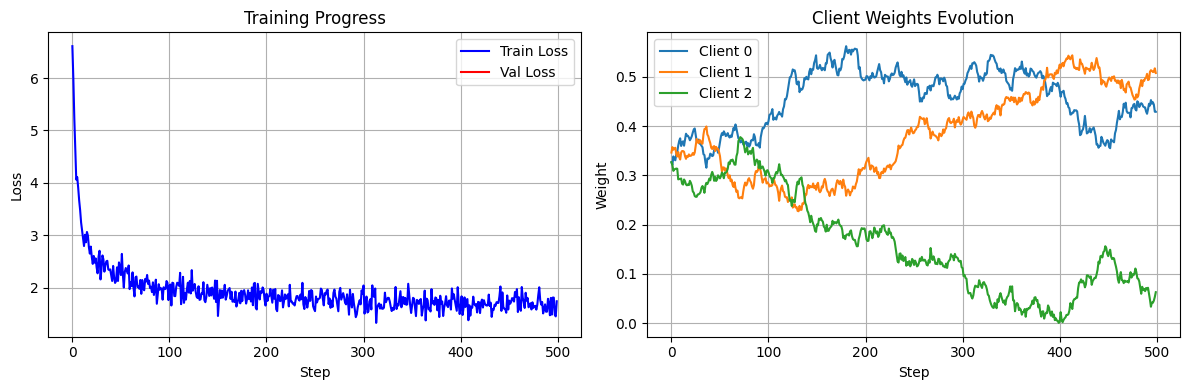

In [41]:
torch.cuda.empty_cache()
try:
    model, tokenizer, logger = main_simple()
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

Клиенты:
* `ENF` -- **энецкие** -- 51777 примеров -- *синим* цветом
* `NGA` -- **нганасанский** -- 34609 примеров -- *рыжим* цветом
* `NEN` -- **ненецкие** -- 10222 примеров -- *зеленым* цветом